DOWNLOADING KAGGLE DATASET VIA API KEYS

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohnishvasan04","key":"f9268300589467861804a029fa41a6b5"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle
#permission for json to act
! chmod 600 ~/.kaggle/kaggle.json
#to list all datasets in kaggle
! kaggle datasets list

ref                                                       title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance      Student Habits vs Academic Performance                 19512  2025-04-12 10:49:08.663000          26425        452  1.0              
adilshamim8/cost-of-international-education               Cost of International Education                        18950  2025-05-07 15:41:53.213000           5761         96  1.0              
adilshamim8/social-media-addiction-vs-relationships       Students' Social Media Addiction                        7851  2025-05-10 14:38:02.713000           3386         54  1.0              
ivankmk/thousand-ml-jobs-in-usa         

In [ ]:
! kaggle datasets download -d 'adityajn105/flickr8k'
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

IMPORT NECESSARY LIBRARIES

In [ ]:
import os
import re
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, concatenate
from sklearn.model_selection import train_test_split
import re
import json
from textwrap import wrap

In [ ]:
# Create the flickr8k directory
os.makedirs('/content/flickr8k', exist_ok=True)

In [ ]:
import zipfile

# Specify the path to your zip file (replace with your actual zip file path)
zip_file_path = '/content/flickr8k.zip'

# Unzip the contents into the flickr8k folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/flickr8k')

In [ ]:
# Check the contents of the flickr8k folder
!ls /content/flickr8k

captions.txt  Images


In [ ]:
# Define dataset paths
IMAGE_DIR = '/content/flickr8k/Images'
CAPTION_FILE = "/content/flickr8k/captions.txt"

READ THE CAPTIONS FILE

In [ ]:
with open(CAPTION_FILE, "r") as f:
    for _ in range(10):  # Print first 10 lines
        print(f.readline())

image,caption

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting

1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .

1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .

1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .



PREPROCESSING

In [ ]:
# Read CSV using the correct comma delimiter and skip the header row
data = pd.read_csv(CAPTION_FILE, delimiter=",", skiprows=1, names=["image", "caption"])

# Remove any spaces and ensure lowercase filenames
data["image"] = data["image"].str.strip().str.lower()

# Debugging: Check first few rows
print("Dataset Preview:")
print(data.head(10))

Dataset Preview:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .  


In [ ]:
# Create a dictionary of available images in lowercase
available_images = {f.lower(): f for f in os.listdir(IMAGE_DIR)}

# Check first 10 images in dataset
print("\n🔍 Checking first 10 images in dataset:")
for img in data["image"].head(10):
    if img in available_images:
        print(f"✅ Image found: {available_images[img]}")
    else:
        print(f"Image not found: {img}")



🔍 Checking first 10 images in dataset:
✅ Image found: 1000268201_693b08cb0e.jpg
✅ Image found: 1000268201_693b08cb0e.jpg
✅ Image found: 1000268201_693b08cb0e.jpg
✅ Image found: 1000268201_693b08cb0e.jpg
✅ Image found: 1000268201_693b08cb0e.jpg
✅ Image found: 1001773457_577c3a7d70.jpg
✅ Image found: 1001773457_577c3a7d70.jpg
✅ Image found: 1001773457_577c3a7d70.jpg
✅ Image found: 1001773457_577c3a7d70.jpg
✅ Image found: 1001773457_577c3a7d70.jpg


In [ ]:
#missing images check
missing_images = [img for img in data["image"] if img.strip().lower() not in available_images]
print("Missing images from dataset:", missing_images[:10])


Missing images from dataset: []


LOAD AND DISPLAY IMAGES

In [ ]:
#Function to load and preprocess images
def read_image(image_path, img_size=224):
    """
    Load an image, resize it, and normalize pixel values.
    """
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize image
    return img

#Function to display a sample of images with captions
def display_images(df, num_images=9):
    df = df.sample(num_images).reset_index(drop=True)
    plt.figure(figsize=(15, 15))

    available_files = {filename.lower(): filename for filename in os.listdir(IMAGE_DIR)}

    found_images = 0

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)

        # Get the normalized image name
        image_name = df.image[i].strip().lower()

        # Try different extensions
        possible_filenames = [image_name, image_name + ".jpg", image_name + ".png", image_name + ".jpeg"]

        image_path = None
        for filename in possible_filenames:
            if filename in available_files:
                image_path = os.path.join(IMAGE_DIR, available_files[filename])
                break

        if image_path and os.path.exists(image_path):
            found_images += 1
            print(f"✅ Image found at: {image_path}")  # Debug print
            img = read_image(image_path)
            plt.imshow(img)
            plt.title("\n".join(wrap(df.caption[i], 20)), fontsize=10)
            plt.axis("off")
        else:
            print(f"❌ Image not found: {df.image[i]}")  # Debug print

    if found_images > 0:
        plt.show()
    else:
        print("No images were found to display.")

✅ Image found at: /content/flickr8k/Images/3259694057_fae7484b0a.jpg
✅ Image found at: /content/flickr8k/Images/3432634159_1eb9a73306.jpg
✅ Image found at: /content/flickr8k/Images/2832453252_a06f7826a8.jpg
✅ Image found at: /content/flickr8k/Images/3608567609_aae96d4a5e.jpg
✅ Image found at: /content/flickr8k/Images/3564543247_05cdbc31cf.jpg
✅ Image found at: /content/flickr8k/Images/2298077331_f9a1488067.jpg
✅ Image found at: /content/flickr8k/Images/3172283002_3c0fc624de.jpg
✅ Image found at: /content/flickr8k/Images/1187435567_18173c148b.jpg
✅ Image found at: /content/flickr8k/Images/2897832422_0cbdb1421e.jpg


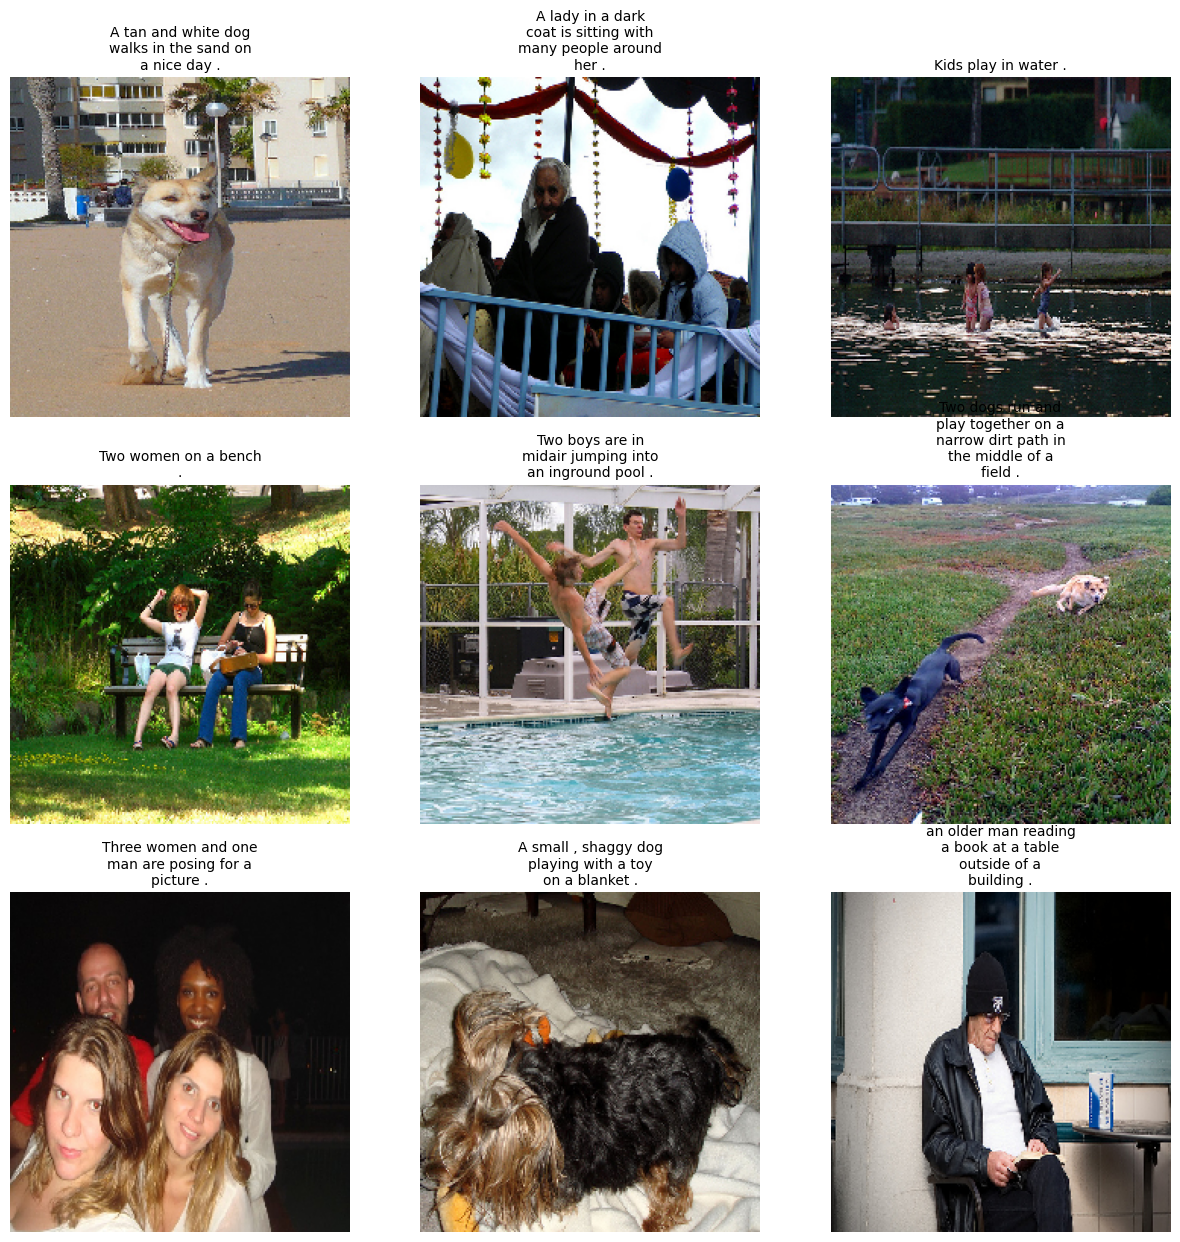

In [ ]:
display_images(data, num_images=9)

PREPROCESSING CAPTIONS

In [ ]:
def load_captions(file_path):
    """
    Loads captions from a CSV file and applies preprocessing:
    - Converts text to lowercase
    - Removes special characters, numbers, and extra spaces
    - Normalizes spacing
    - Removes single-character words
    - Adds <start> and <end> tokens for training

    Arguments:
    - file_path (str): Path to the caption file.

    Returns:
    - captions_dict (dict): Dictionary mapping image IDs to a list of cleaned captions.
    """
    captions_dict = {}

    # Read CSV file (handle missing values)
    df = pd.read_csv(file_path, header=None, names=['image', 'caption'], on_bad_lines='skip')

    for _, row in df.iterrows():
        img_id = str(row['image']).strip().lower()  # Ensure lowercase
        caption = str(row['caption']).lower() if pd.notna(row['caption']) else ""  # Handle NaN values

        # Remove file extensions from image IDs
        img_id = img_id.split('.')[0]

        # Remove special characters, numbers, and extra spaces
        caption = re.sub(r"[^a-z ]", "", caption)
        caption = re.sub(r"\s+", " ", caption).strip()

        # Remove single-character words (e.g., isolated letters)
        caption = " ".join([word for word in caption.split() if len(word) > 1])

        if caption:  # Only add valid captions
            caption = f"<start> {caption} <end>"
            if img_id not in captions_dict:
                captions_dict[img_id] = []
            captions_dict[img_id].append(caption)

    return captions_dict

# Load and preprocess captions
captions_dict = load_captions(CAPTION_FILE)

# Debug: Print a sample of processed captions
print(list(captions_dict.items())[:5])

[('image', ['<start> caption <end>']), ('1000268201_693b08cb0e', ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>']), ('1001773457_577c3a7d70', ['<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>']), ('1002674143_1b742ab4b8', ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>', '<start> little girl is sitting in front of large painted rainbow <end>

In [ ]:
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

# Ensure stopwords are available
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))


# Function to preprocess captions (remove stopwords)
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply preprocessing to captions
all_captions = [remove_stopwords(cap) for caps in captions_dict.values() for cap in caps]

# Tokenizer setup
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>", filters='"#$%&()*+-/;<=>@[\\]^_`{|}~')
tokenizer.fit_on_texts(all_captions)

# Function to tokenize captions
def tokenize_caption(caption):
    return tokenizer.texts_to_sequences([caption])[0]  # Convert to sequence of numbers

# Vocabulary size (add 1 for padding token)
vocab_size = len(tokenizer.word_index) + 1

# Debug: Print tokenizer details
print(f"Vocabulary Size: {vocab_size}")
print("Sample Tokenized Words:", list(tokenizer.word_index.items())[:10])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Vocabulary Size: 8657
Sample Tokenized Words: [('<unk>', 1), ('end', 2), ('start', 3), ('dog', 4), ('man', 5), ('two', 6), ('white', 7), ('black', 8), ('boy', 9), ('woman', 10)]


In [ ]:
# Save tokenizer as JSON
with open("tokenizer.json", "w") as f:
    json.dump(tokenizer.to_json(), f)

# Save captions dictionary as JSON
with open("captions_dict.json", "w") as f:
    json.dump(captions_dict, f)

print("✅ Preprocessing complete! Captions and tokenizer saved.")

✅ Preprocessing complete! Captions and tokenizer saved.


DISPLAY PREPROCESSED IMAGES

✅ Image found: /content/flickr8k/Images/240583223_e26e17ee96.jpg
✅ Image found: /content/flickr8k/Images/2198484810_50a893824a.jpg
✅ Image found: /content/flickr8k/Images/2274602044_b3d55df235.jpg
✅ Image found: /content/flickr8k/Images/360723732_23199af4bf.jpg
✅ Image found: /content/flickr8k/Images/2455286250_fb6a66175a.jpg
✅ Image found: /content/flickr8k/Images/3695064885_a6922f06b2.jpg
✅ Image found: /content/flickr8k/Images/2342478660_faef1afea8.jpg
✅ Image found: /content/flickr8k/Images/1417031097_ab656bc4bd.jpg
✅ Image found: /content/flickr8k/Images/2949880800_ca9a1bb7e6.jpg


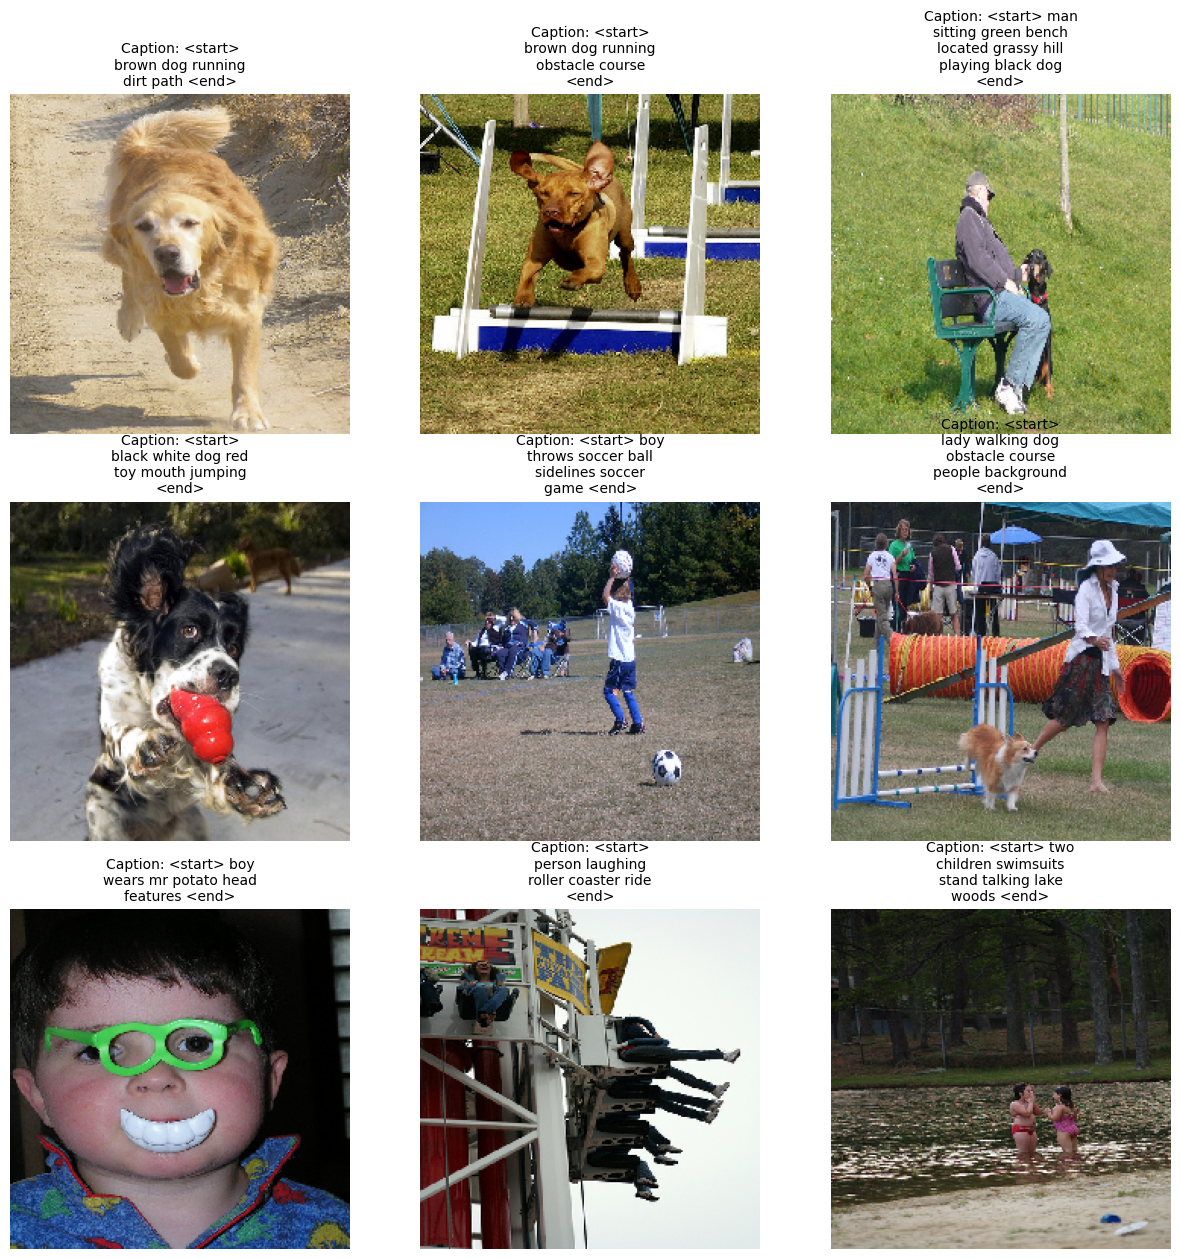

In [ ]:
from PIL import Image
import random

def display_preprocessed_images(captions_dict, num_images=9):
    """
    Displays a sample of images with their preprocessed captions.

    Arguments:
    - captions_dict (dict): Dictionary where keys are image IDs (without extensions)
      and values are lists of cleaned captions.
    - num_images (int): Number of images to display (default = 9).
    """
    # Select random image IDs from the captions dictionary
    selected_image_ids = random.sample(list(captions_dict.keys()), min(num_images, len(captions_dict)))

    plt.figure(figsize=(15, 15))

    for i, img_id in enumerate(selected_image_ids):
        plt.subplot(3, 3, i + 1)

        # Find the corresponding image file in the IMAGE_DIR
        image_path = None
        for filename in os.listdir(IMAGE_DIR):
            if filename.lower().startswith(img_id):  # Match image name without extension
                image_path = os.path.join(IMAGE_DIR, filename)
                break  # Stop searching once found

        if image_path and os.path.exists(image_path):
            print(f"✅ Image found: {image_path}")  # Debugging confirmation
            img = read_image(image_path)
            plt.imshow(img)

            # Get the first preprocessed caption
            clean_caption = remove_stopwords(captions_dict[img_id][0])
            tokenized_caption = tokenize_caption(clean_caption)

            # Convert tokenized caption back to words (for debugging)
            tokenized_words = [word for word, index in tokenizer.word_index.items() if index in tokenized_caption]

            # Display captions
            plt.title("\n".join(wrap(f"Caption: {clean_caption}", 20)), fontsize=10)
            plt.axis("off")
        else:
            print(f"❌ Image not found for ID: {img_id}")  # Debugging

    plt.show()

# ✅ Call the function to visualize preprocessed captions
display_preprocessed_images(captions_dict, num_images=9)

FEATURE EXTRACTION

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_effnet

In [ ]:
#Load Pretrained Models (Feature Extraction)
vgg_model = VGG16(weights="imagenet", include_top=False, pooling='avg')
effnet_model = EfficientNetB0(weights="imagenet", include_top=False, pooling='avg')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Feature Extraction Function (Batch Processing)
def extract_features_batch(image_paths):
    batch_size = len(image_paths)
    img_arrays = []

    for img_path in image_paths:
        try:
            # Load and preprocess image for VGG16 & EfficientNet
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_arrays.append(img_array)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img_arrays.append(None)

    # Convert list to NumPy array
    img_arrays = np.vstack([img for img in img_arrays if img is not None])

    # Extract Features (Efficient Batch Processing)
    vgg_features = vgg_model.predict(preprocess_vgg(img_arrays), verbose=0)
    effnet_features = effnet_model.predict(preprocess_effnet(img_arrays), verbose=0)

    # Combine Features
    combined_features = np.concatenate((vgg_features, effnet_features), axis=1)

    return combined_features

EXTRACTING AND SAVING FEATURES

In [ ]:
#Extract and Save Features for All Images
IMAGE_DIR = "/content/flickr8k/Images"
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_paths = [os.path.join(IMAGE_DIR, f) for f in image_files]

image_features = {}

batch_size = 32

for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting Features"):
    batch_paths = image_paths[i:i + batch_size]
    batch_features = extract_features_batch(batch_paths)

    for j, img_path in enumerate(batch_paths):
        img_file = os.path.basename(img_path)
        image_features[img_file] = batch_features[j]

#Save Extracted Features
with open("image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)

print("Feature extraction completed and saved!")

Extracting Features:   0%|          | 0/253 [00:00<?, ?it/s]

Feature extraction completed and saved!


CREATING DICTIONARY OF CAPTIONS INTO TOKEN SEQUENCE

In [ ]:
# Compute max_length from your captions (captions_dict)
max_length = max(len(caption.split()) for captions in captions_dict.values() for caption in captions)
print("Max caption length:", max_length)

def captions_to_sequences(captions_dict, tokenizer, max_length):
    """
    Converts a dictionary of captions into token sequences.

    Arguments:
    - captions_dict: dict mapping image IDs (without extension) to a list of captions.
    - tokenizer: Keras Tokenizer fitted on your caption texts.
    - max_length: Maximum caption length (for padding).

    Returns:
    - sequences: dict mapping image IDs to lists of padded token sequences.
    """
    sequences = {}
    for img_id, captions in captions_dict.items():
        sequences[img_id] = []
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]
            seq = pad_sequences([seq], maxlen=max_length, padding='post')[0]
            sequences[img_id].append(seq)
    return sequences

# Convert captions to sequences (this creates 'train_sequences')
train_sequences = captions_to_sequences(captions_dict, tokenizer, max_length)
print("Sample tokenized caption:", list(train_sequences.items())[0])

Max caption length: 34
Sample tokenized caption: ('image', [array([3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)])


In [ ]:
all_examples = []
for feat_key, feature in image_features.items():
    # Remove file extension to match keys in train_sequences
    key_no_ext = os.path.splitext(feat_key)[0]
    if key_no_ext in train_sequences:
        for seq in train_sequences[key_no_ext]:
            # For each caption, create multiple training examples
            # Each example is (feature, input sequence so far, next word)
            for i in range(1, len(seq)):
                input_seq = seq[:i]
                next_word = seq[i]
                all_examples.append((feature, input_seq, next_word))

print("Total training examples:", len(all_examples))

Total training examples: 1334949


DATA SPLITTING AND GENERATION

In [ ]:
# Here we split the unified examples (using an 80/10/10 split)
train_examples, temp_examples = train_test_split(all_examples, test_size=0.2, random_state=42)
val_examples, test_examples = train_test_split(temp_examples, test_size=0.5, random_state=42)

print("Training examples:", len(train_examples))
print("Validation examples:", len(val_examples))
print("Test examples:", len(test_examples))

Training examples: 1067959
Validation examples: 133495
Test examples: 133495


In [ ]:
from tensorflow.keras.utils import to_categorical

class UnifiedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, examples, batch_size, max_length, vocab_size):
        """
        examples: List of tuples (feature, input_seq, next_word)
        batch_size: Number of examples per batch.
        max_length: Maximum length for input caption sequences.
        vocab_size: Total number of tokens in the vocabulary.
        """
        self.examples = examples
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size

    def __len__(self):
        return int(np.floor(len(self.examples) / self.batch_size))

    def __getitem__(self, index):
        batch = self.examples[index * self.batch_size:(index+1) * self.batch_size]
        X_images, X_texts, Y = [], [], []
        for feature, input_seq, next_word in batch:
            X_images.append(feature)  # Image feature vector
            X_texts.append(input_seq)  # Partial caption sequence (list of word indices)
            Y.append(to_categorical(next_word, num_classes=self.vocab_size))
        # Pad the caption sequences to uniform length
        X_texts = pad_sequences(X_texts, maxlen=self.max_length, padding='post')
        # Return as tuples (not lists)
        return (np.array(X_images), np.array(X_texts)), np.array(Y)


In [ ]:
batch_size = 64

# Create unified generators for training, validation, and test sets
train_generator_unified = UnifiedDataGenerator(train_examples, batch_size, max_length, vocab_size)
val_generator_unified = UnifiedDataGenerator(val_examples, batch_size, max_length, vocab_size)
test_generator_unified = UnifiedDataGenerator(test_examples, batch_size, max_length, vocab_size)

print("✅ Unified Data Generators Created!")

✅ Unified Data Generators Created!


FEATURE DIMENSION (1D)

In [ ]:
# Determine the dimension of image features.
# We assume each feature vector is 1D.
sample_key = list(image_features.keys())[0]
sample_feature = image_features[sample_key]
print("Sample feature shape:", sample_feature.shape)
# Use shape[0] since feature vectors are 1D
feature_dim = sample_feature.shape[0]
print("Feature dimension:", feature_dim)

'''VGG16 (using include_top=False and pooling='avg') produces a 512-dimensional vector.
EfficientNetB0 (using the same configuration) produces a 1280-dimensional vector.
When concatenated, they yield a vector of 512 + 1280 = 1792 dimensions'''

Sample feature shape: (1792,)
Feature dimension: 1792


"VGG16 (using include_top=False and pooling='avg') produces a 512-dimensional vector.\nEfficientNetB0 (using the same configuration) produces a 1280-dimensional vector.\nWhen concatenated, they yield a vector of 512 + 1280 = 1792 dimensions"

MODEL SELECTION : CNN - LSTM

In [ ]:
# Model parameters
embedding_dim = 256
lstm_units = 256

# Image features branch
inputs1 = Input(shape=(feature_dim,), name="image_features")
fe = Dropout(0.5)(inputs1)
fe = Dense(256, activation='relu')(fe)

In [ ]:
# Caption sequence branch
inputs2 = Input(shape=(max_length,), name="caption_sequence")
se = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se = Dropout(0.5)(se)
se = LSTM(lstm_units)(se)

# Combine image features and caption branch
decoder = add([fe, se])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

cnn_lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_sequence    │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 1792)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,216,192 │ caption_sequence… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1792)      │          0 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ caption_sequence… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    459,008 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8657)      │  2,224,849 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,491,153 (20.95 MB)

 Trainable params: 5,491,153 (20.95 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL

In [ ]:
epochs = 15  # Adjust epochs as needed
history = cnn_lstm_model.fit(train_generator_unified,
                             validation_data=val_generator_unified,
                             epochs=epochs)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16686/16686 ━━━━━━━━━━━━━━━━━━━━ 282s 17ms/step - accuracy: 0.7961 - loss: 1.3284 - val_accuracy: 0.8079 - val_loss: 1.1324
Epoch 2/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 276s 17ms/step - accuracy: 0.8106 - loss: 1.0977 - val_accuracy: 0.8104 - val_loss: 1.1070
Epoch 3/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 323s 17ms/step - accuracy: 0.8118 - loss: 1.0595 - val_accuracy: 0.8110 - val_loss: 1.1031
Epoch 4/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 279s 17ms/step - accuracy: 0.8129 - loss: 1.0410 - val_accuracy: 0.8096 - val_loss: 1.0938
Epoch 5/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 280s 17ms/step - accuracy: 0.8139 - loss: 1.0271 - val_accuracy: 0.8108 - val_loss: 1.0969
Epoch 6/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 278s 17ms/step - accuracy: 0.8146 - loss: 1.0216 - val_accuracy: 0.8116 - val_loss: 1.1011
Epoch 7/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 277s 17ms/step - accuracy: 0.8147 - loss: 1.0184 - val_accuracy: 0.8104 - val_loss: 1.1064
Epoch 8/15
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 277s 17ms/step - accur

In [ ]:
print("Baseline CNN-LSTM Training Accuracy per Epoch:")
print(history.history['accuracy'])
print("Baseline CNN-LSTM Validation Accuracy per Epoch:")
print(history.history['val_accuracy'])

Baseline CNN-LSTM Training Accuracy per Epoch:
[0.8034542202949524, 0.8102554082870483, 0.8119596838951111, 0.8126816749572754, 0.8134438991546631, 0.8137669563293457, 0.8137810230255127, 0.8141312599182129, 0.8139514327049255, 0.8138625025749207, 0.813575029373169, 0.8134607672691345, 0.8133727312088013, 0.8136461973190308, 0.813412070274353]
Baseline CNN-LSTM Validation Accuracy per Epoch:
[0.8078536987304688, 0.8104091882705688, 0.8110461831092834, 0.8096373081207275, 0.8108363151550293, 0.81156325340271, 0.8104316592216492, 0.8112934827804565, 0.8103867173194885, 0.810783863067627, 0.809315025806427, 0.809937059879303, 0.8098246455192566, 0.8095623254776001, 0.8097571730613708]


In [ ]:
cnn_lstm_model.save('cnn_lstm_captioning_model.keras')
print("✅ Model saved!")


✅ Model saved!


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
cnn_lstm_model = load_model('cnn_lstm_captioning_model.keras')
print("✅ Model loaded!")


✅ Model loaded!


In [ ]:
# Create a mapping from feature vectors to image IDs (for fast lookup)
feature_to_id = {tuple(img_feature): os.path.splitext(img_key)[0] for img_key, img_feature in image_features.items()}

# Extract test image IDs using direct lookup
test_image_ids = {feature_to_id.get(tuple(feature)) for feature, _, _ in test_examples if tuple(feature) in feature_to_id}

# Remove any None values (if unmatched)
test_image_ids.discard(None)

# Filter test captions efficiently
test_captions = {img_id: captions_dict[img_id] for img_id in test_image_ids if img_id in captions_dict}

print(f"✅ Total Test Captions Loaded: {len(test_captions)}")


✅ Total Test Captions Loaded: 8090


In [ ]:
print(f"Total test captions: {len(test_captions)}")
print(f"Sample test captions: {list(test_captions.items())[:5]}")

Total test captions: 8090
Sample test captions: [('3160531982_37f5636b8a', ['<start> parachute is making his landing as the sunsets behind him <end>', '<start> person is parasailing as the sun sets <end>', '<start> person paraglides at sundown <end>', '<start> silhouette of figure parachuting at sunset <end>', '<start> with the sun rising person is gliding with huge parachute attached to them <end>']), ('2453318633_550228acd4', ['<start> brown and black dog is jumping through ring of fire <end>', '<start> brown and black dog jumping through hoop of fire <end>', '<start> dog jumping through ring of fire <end>', '<start> german shepherd is jumping through ring on fire <end>', '<start> tan and black dog leaps through burning hoop on field <end>']), ('2667015110_1670324a33', ['<start> child in an orange shirt with book <end>', '<start> young asian boy in orange longsleeved tshirt holds magazine <end>', '<start> young boy is holding book <end>', '<start> the boy wearing an orange sweater is

In [ ]:
image_features = {os.path.splitext(img_id)[0]: feature for img_id, feature in image_features.items()}
print(f"Total test captions: {len(test_captions)}")
missing_features = [img_id for img_id in test_captions if img_id not in image_features]
print(f"⚠️ Missing image features count: {len(missing_features)}")

# Ensure <start> and <end> tokens are in the tokenizer
special_tokens = ['<start>', '<end>']
for token in special_tokens:
    if token not in tokenizer.word_index:
        tokenizer.word_index[token] = len(tokenizer.word_index) + 1
        tokenizer.index_word[len(tokenizer.word_index)] = token  # Add reverse mapping

print("✅ Special tokens ensured in tokenizer")

Total test captions: 8090
⚠️ Missing image features count: 0
✅ Special tokens ensured in tokenizer


BLEU SCORE FOR CNN-LSTM

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption_cnn_lstm(image_feature, tokenizer, max_length):
    input_seq = [tokenizer.word_index.get('<start>', 1)]
    caption = []

    for _ in range(max_length):
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')
        y_pred = cnn_lstm_model.predict([np.array([image_feature]), padded_seq], verbose=0)
        next_word_idx = np.argmax(y_pred[0])

        if next_word_idx == tokenizer.word_index.get('<end>', 2):
            break

        word = tokenizer.index_word.get(next_word_idx)
        if word:
            caption.append(word)
            input_seq.append(next_word_idx)

    return ' '.join(caption)

# Evaluate BLEU
def evaluate_bleu_cnn_lstm(image_features, test_captions, tokenizer, max_length, sample_count=100):
    bleu_scores = []
    smooth = SmoothingFunction().method4
    tested = 0

    print("\n📊 Evaluating CNN-LSTM Model on Test Images...\n")

    for img_id, captions in test_captions.items():
        if tested >= sample_count:
            break

        if img_id not in image_features:
            continue

        feature = image_features[img_id]
        caption = generate_caption_cnn_lstm(feature, tokenizer, max_length)

        if not caption.strip():
            continue

        references = [c.strip().lower().split() for c in captions]
        candidate = caption.strip().lower().split()

        bleu = sentence_bleu(references, candidate, weights=(0.7, 0.2, 0.1, 0.0))

        tested += 1

    if bleu_scores:
        avg_bleu = np.mean(bleu_scores)
        print(f"✅ Final BLEU Score (CNN-LSTM) : {avg_bleu:.4f}")
    else:
        print("❌ No valid BLEU scores could be computed.")

# Run Evaluation
evaluate_bleu_cnn_lstm(image_features, test_captions, tokenizer, max_length, sample_count=100)



📊 Evaluating CNN-LSTM Model on Test Images...

✅ Final BLEU Score (CNN-LSTM) : 0.3000


MODEL SELECTION: BLIP

In [ ]:
!pip install transformers pillow nltk

In [ ]:
pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-ord9o2hw
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-ord9o2hw
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=ebf1073cf4d5209b40bfcde81c558440478e486d6c3ebbcd2c68421b797b8678
  Stored in directory: /tmp/pip-ephem-wheel-cache-puoyppq2/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [ ]:
import os
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pycocoevalcap.cider.cider import Cider

In [ ]:
# Load larger BLIP model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)


In [ ]:
from PIL import Image
blip_model = blip_model.to(device)  # make sure model is on device

# Updated function
def generate_caption_blip(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, return_tensors="pt").to(device)  # Move inputs to GPU
    blip_model.eval()
    with torch.no_grad():
        output_ids = blip_model.generate(**inputs, num_beams=5, max_length=30)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption.strip().lower()

In [ ]:
from sklearn.model_selection import train_test_split

# Get all image IDs from your captions dictionary
all_ids = list(captions_dict.keys())

# Split into train and test (e.g., 90% train, 10% test)
train_ids, test_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

# Create a test_captions dictionary from the original captions_dict
test_captions = {img_id: captions_dict[img_id] for img_id in test_ids}
print("Number of test images:", len(test_captions))

Number of test images: 810


BLEU SCORE

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import string

# Preprocessing and smoothing
def preprocess_caption(caption):
    return caption.lower().translate(str.maketrans('', '', string.punctuation)).strip()

# Smoother function
smoother = SmoothingFunction().method7

# BLEU computation
sample_count = len(test_captions)
tested = 0
bleu_scores = []

for img_id, captions in list(test_captions.items())[:sample_count]:
    if tested >= sample_count:
        break

    if not captions:
        continue

    reference = [preprocess_caption(cap).split() for cap in captions if cap.strip()]
    if not reference:
        continue

    image_path = next(
        (os.path.join(IMAGE_DIR, img_id + ext)
         for ext in [".jpg", ".jpeg", ".png"]
         if os.path.exists(os.path.join(IMAGE_DIR, img_id + ext))),
        None
    )
    if not image_path:
        continue

    generated_caption = generate_caption_blip(image_path)
    if not generated_caption or not isinstance(generated_caption, str):
        continue

    candidate = preprocess_caption(generated_caption).split()
    if len(candidate) < 4:
        continue

    bleu = sentence_bleu(reference, candidate,
                         weights=(0.8, 0.15, 0.05, 0.0))
    bleu_scores.append(bleu)
    tested += 1

# Final BLEU score report
if bleu_scores:
    avg_bleu = np.mean(bleu_scores)
    print(f"\n📊 Average BLEU score : {avg_bleu:.4f}")
else:
    print("❌ No valid BLEU scores computed.")



📊 Average BLEU score : 0.5757


CIDER & METEOR SCORE

In [ ]:
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

# Prepare data structures
gts = {}
res = {}

# Limit samples
sample_count = 100
evaluated = 0

for i, (img_id, ref_captions) in enumerate(test_captions.items()):
    if evaluated >= sample_count:
        break

    image_path = None
    for ext in [".jpg", ".jpeg", ".png"]:
        candidate_path = os.path.join(IMAGE_DIR, img_id + ext)
        if os.path.exists(candidate_path):
            image_path = candidate_path
            break
    if not image_path:
        continue

    try:
        gen_caption = generate_caption_blip(image_path)
    except:
        continue

    if not gen_caption:
        continue

    # Preprocess both reference and generated captions
    processed_refs = [cap.strip().lower() for cap in ref_captions]
    gts[i] = processed_refs
    res[i] = [gen_caption.strip().lower()]
    evaluated += 1

# Compute CIDEr score
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)

# Compute METEOR score
meteor_scorer = Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)

# Print final scores
print(f"\n📊 CIDEr Score:  {cider_score:.2f}")
print(f"📊 METEOR Score: {meteor_score:.2f}")



📊 CIDEr Score:  0.52
📊 METEOR Score: 0.14


GENERATE CAPTIONS

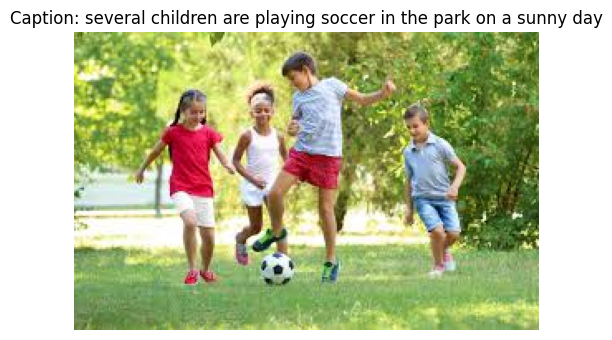

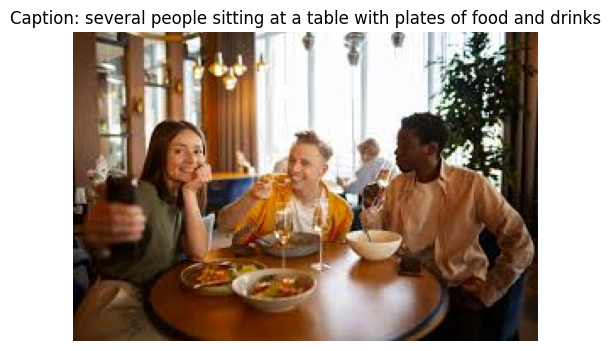

In [ ]:
image_paths = ["image1.jpg", "image2.jpg"]

# Generate captions
for path in image_paths:
    try:
        caption = generate_caption_blip(path)
        image = Image.open(path).convert("RGB")
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Caption: {caption}", fontsize=12)
        plt.show()
    except Exception as e:
        print(f"❌ Failed to process {path}: {e}")